# Adversarial-Robustness-Toolbox for scikit-learn RandomForestClassifier

In [54]:
from sklearn.ensemble import RandomForestClassifier


import numpy as np
from matplotlib import pyplot as plt

from art.estimators.classification import SklearnClassifier
from art.attacks.evasion import ZooAttack
from art.utils import load_mnist

import warnings
warnings.filterwarnings('ignore')

In [55]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree

from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

data=pd.read_csv('dataset.csv')

# clean up column names

data.columns = data.columns.\
    str.strip().\
    str.lower()

#____remove non-numeric columns
    
data = data.select_dtypes(['number']) 


#__extracting dependent and independent variable

x=data.drop(['type'],axis=1)
y=data['type']
x=np.nan_to_num(x) #____replace nan with zero and inf with finite numbers


#df preprocess for art
data=data[['url_length','number_special_characters','content_length','app_bytes']]
data=data.to_numpy()

In [56]:
data

array([[1.6000e+01, 7.0000e+00, 2.6300e+02, 7.0000e+02],
       [1.6000e+01, 6.0000e+00, 1.5087e+04, 1.2300e+03],
       [1.6000e+01, 6.0000e+00, 3.2400e+02, 0.0000e+00],
       ...,
       [2.0100e+02, 3.4000e+01, 8.9040e+03, 6.6310e+03],
       [2.3400e+02, 3.4000e+01,        nan, 0.0000e+00],
       [2.4900e+02, 4.0000e+01, 2.4435e+04, 2.3140e+03]])

## 1 Training scikit-learn RandomForestClassifier and attacking with ART Zeroth Order Optimization attack

In [57]:
def get_adversarial_examples(x_train, y_train):
    
    # Create and fit RandomForestClassifier
    model = RandomForestClassifier()
    model.fit(X=x_train, y=y_train)

    # Create ART classfier for scikit-learn RandomForestClassifier
    art_classifier = SklearnClassifier(model=model)

    # Create ART Zeroth Order Optimization attack
    zoo = ZooAttack(classifier=art_classifier, confidence=0.0, targeted=False, learning_rate=1e-1, max_iter=20,
                    binary_search_steps=10, initial_const=1e-3, abort_early=True, use_resize=False, 
                    use_importance=False, nb_parallel=1, batch_size=1, variable_h=0.2)

    # Generate adversarial samples with ART Zeroth Order Optimization attack
    x_train_adv = zoo.generate(x_train)

    return x_train_adv, model

## 1.1 Utility functions

In [58]:
def get_data(num_classes):
    x_train, y_train = data
    x_train = x_train[y_train < num_classes][:, [0, 1]]
    y_train = y_train[y_train < num_classes]
    x_train[:, 0][y_train == 0] *= 2
    x_train[:, 1][y_train == 2] *= 2
    x_train[:, 0][y_train == 0] -= 3
    x_train[:, 1][y_train == 2] -= 2
    
    x_train[:, 0] = (x_train[:, 0] - 4) / (9 - 4)
    x_train[:, 1] = (x_train[:, 1] - 1) / (6 - 1)
    
    return x_train, y_train

In [48]:
def plot_results(model, x_train, y_train, x_train_adv, num_classes):
    fig, axs = plt.subplots(1, num_classes, figsize=(num_classes * 5, 5))

    colors = ['orange', 'blue', 'green']

    for i_class in range(num_classes):

        # Plot difference vectors
        for i in range(y_train[y_train == i_class].shape[0]):
            x_1_0 = x_train[y_train == i_class][i, 0]
            x_1_1 = x_train[y_train == i_class][i, 1]
            x_2_0 = x_train_adv[y_train == i_class][i, 0]
            x_2_1 = x_train_adv[y_train == i_class][i, 1]
            if x_1_0 != x_2_0 or x_1_1 != x_2_1:
                axs[i_class].plot([x_1_0, x_2_0], [x_1_1, x_2_1], c='black', zorder=1)

        # Plot benign samples
        for i_class_2 in range(num_classes):
            axs[i_class].scatter(x_train[y_train == i_class_2][:, 0], x_train[y_train == i_class_2][:, 1], s=20,
                                 zorder=2, c=colors[i_class_2])
        axs[i_class].set_aspect('equal', adjustable='box')

        # Show predicted probability as contour plot
        h = .01
        x_min, x_max = 0, 1
        y_min, y_max = 0, 1

        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        Z_proba = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])
        Z_proba = Z_proba[:, i_class].reshape(xx.shape)
        im = axs[i_class].contourf(xx, yy, Z_proba, levels=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                   vmin=0, vmax=1)
        if i_class == num_classes - 1:
            cax = fig.add_axes([0.95, 0.2, 0.025, 0.6])
            plt.colorbar(im, ax=axs[i_class], cax=cax)

        # Plot adversarial samples
        for i in range(y_train[y_train == i_class].shape[0]):
            x_1_0 = x_train[y_train == i_class][i, 0]
            x_1_1 = x_train[y_train == i_class][i, 1]
            x_2_0 = x_train_adv[y_train == i_class][i, 0]
            x_2_1 = x_train_adv[y_train == i_class][i, 1]
            if x_1_0 != x_2_0 or x_1_1 != x_2_1:
                axs[i_class].scatter(x_2_0, x_2_1, zorder=2, c='red', marker='X')
        axs[i_class].set_xlim((x_min, x_max))
        axs[i_class].set_ylim((y_min, y_max))

        axs[i_class].set_title('class ' + str(i_class))
        axs[i_class].set_xlabel('feature 1')
        axs[i_class].set_ylabel('feature 2')

# 2 Example: Iris dataset

### legend
- colored background: probability of class i
- orange circles: class 1
- blue circles: class 2
- green circles: class 3
- red crosses: adversarial samples for class i

In [49]:
num_classes = 2
x_train, y_train = get_data(num_classes=num_classes)
x_train_adv, model = get_adversarial_examples(x_train, y_train)
plot_results(model, x_train, y_train, x_train_adv, num_classes)

ValueError: too many values to unpack (expected 2)

In [50]:
num_classes = 3
x_train, y_train = get_data(num_classes=num_classes)
x_train_adv, model = get_adversarial_examples(x_train, y_train)
plot_results(model, x_train, y_train, x_train_adv, num_classes)

ValueError: too many values to unpack (expected 2)

## 3.2 Train RandomForestClassifier classifier

In [52]:
model = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None, min_samples_split=2, 
                               min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', 
                               max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, 
                               bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, 
                               warm_start=False, class_weight=None)

In [53]:
model.fit(X=x_train, y=y_train);

## 3.3 Create and apply Zeroth Order Optimization Attack with ART

In [10]:
art_classifier = SklearnClassifier(model=model)

In [11]:
zoo = ZooAttack(classifier=art_classifier, confidence=0.0, targeted=False, learning_rate=1e-1, max_iter=100,
                binary_search_steps=20, initial_const=1e-3, abort_early=True, use_resize=False, 
                use_importance=False, nb_parallel=10, batch_size=1, variable_h=0.25)

In [12]:
x_train_adv = zoo.generate(x_train)

ZOO: 100%|███████████████████████████████████████████████████████████████████████████| 200/200 [04:49<00:00,  1.45s/it]


In [13]:
x_test_adv = zoo.generate(x_test)

ZOO: 100%|███████████████████████████████████████████████████████████████████████████| 200/200 [03:52<00:00,  1.16s/it]


## 3.4 Evaluate RandomForestClassifier on benign and adversarial samples

In [14]:
score = model.score(x_train, y_train)
print("Benign Training Score: %.4f" % score)

Benign Training Score: 1.0000


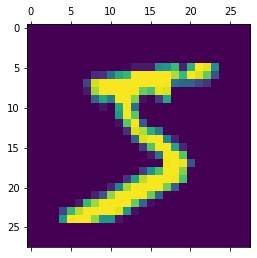

In [15]:
plt.matshow(x_train[0, :].reshape((28, 28)))
plt.clim(0, 1)

In [16]:
prediction = model.predict(x_train[0:1, :])[0]
print("Benign Training Predicted Label: %i" % prediction)

Benign Training Predicted Label: 5


In [17]:
score = model.score(x_train_adv, y_train)
print("Adversarial Training Score: %.4f" % score)

Adversarial Training Score: 0.3150


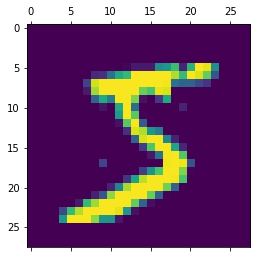

In [18]:
plt.matshow(x_train_adv[0, :].reshape((28, 28)))
plt.clim(0, 1)

In [19]:
prediction = model.predict(x_train_adv[0:1, :])[0]
print("Adversarial Training Predicted Label: %i" % prediction)

Adversarial Training Predicted Label: 2


In [20]:
score = model.score(x_test, y_test)
print("Benign Test Score: %.4f" % score)

Benign Test Score: 0.6150


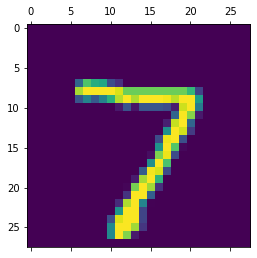

In [21]:
plt.matshow(x_test[0, :].reshape((28, 28)))
plt.clim(0, 1)

In [22]:
prediction = model.predict(x_test[0:1, :])[0]
print("Benign Test Predicted Label: %i" % prediction)

Benign Test Predicted Label: 7


In [23]:
score = model.score(x_test_adv, y_test)
print("Adversarial Test Score: %.4f" % score)

Adversarial Test Score: 0.2450


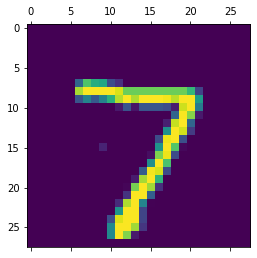

In [24]:
plt.matshow(x_test_adv[0, :].reshape((28, 28)))
plt.clim(0, 1)

In [25]:
prediction = model.predict(x_test_adv[0:1, :])[0]
print("Adversarial Test Predicted Label: %i" % prediction)

Adversarial Test Predicted Label: 4


In [34]:
load_iris(return_X_y=True)

(array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
        [5

In [39]:
data=data[['url_length','number_special_characters','content_length','app_bytes']]

In [40]:
data

,url_length,number_special_characters,content_length,app_bytes
0,16,7,263.0,700
1,16,6,15087.0,1230
2,16,6,324.0,0
3,17,6,162.0,3812
4,17,6,124140.0,4278
...,...,...,...,...
1776,194,16,NaN,0
1777,198,17,NaN,0
1778,201,34,8904.0,6631
1779,234,34,NaN,0


In [41]:
data.to_numpy()

array([[1.6000e+01, 7.0000e+00, 2.6300e+02, 7.0000e+02],
       [1.6000e+01, 6.0000e+00, 1.5087e+04, 1.2300e+03],
       [1.6000e+01, 6.0000e+00, 3.2400e+02, 0.0000e+00],
       ...,
       [2.0100e+02, 3.4000e+01, 8.9040e+03, 6.6310e+03],
       [2.3400e+02, 3.4000e+01,        nan, 0.0000e+00],
       [2.4900e+02, 4.0000e+01, 2.4435e+04, 2.3140e+03]])

In [36]:
x_train, y_train = load_iris(return_X_y=True)

In [37]:
x_train

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

In [38]:
y_train

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])